# Downloading Dependencies

In [ ]:
!pip install opencv-python

# Used Libraries

In [ ]:
import cv2
from google.colab.patches import cv2_imshow
import numpy as np
import matplotlib.pyplot as plt

# Preparing The Picture

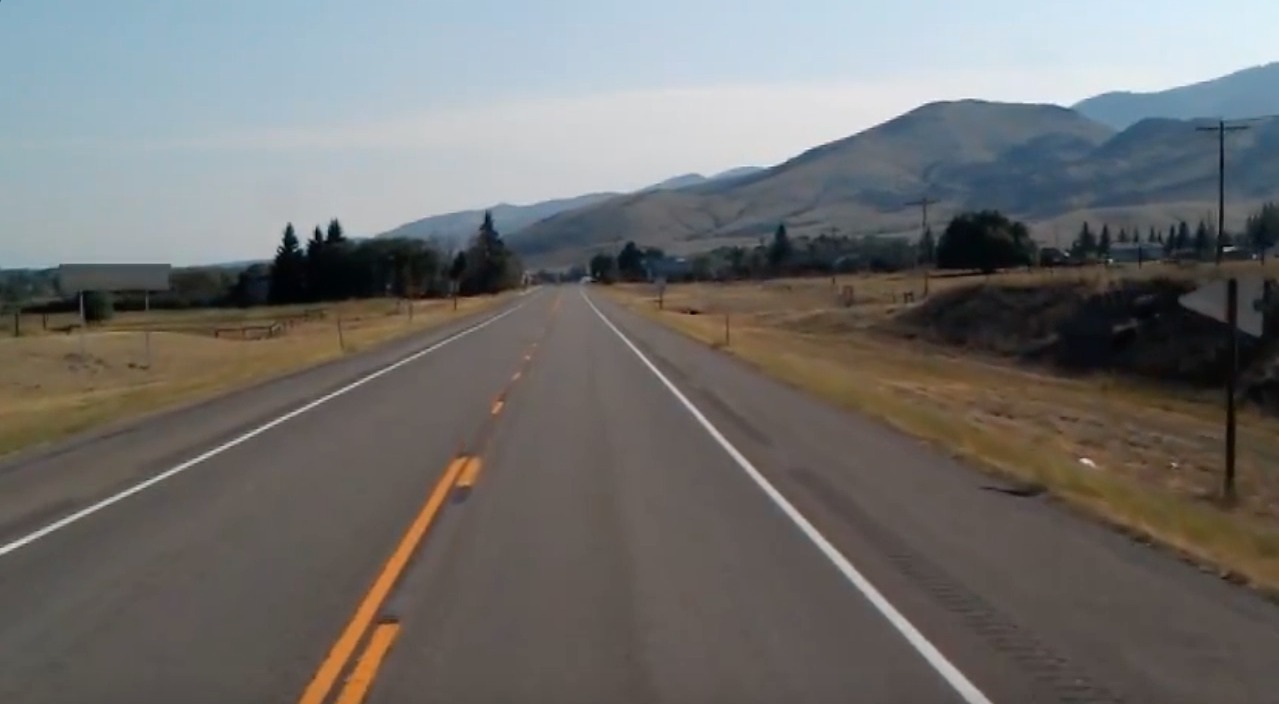

In [ ]:
image = cv2.imread('Picture.png')
cv2_imshow(image)

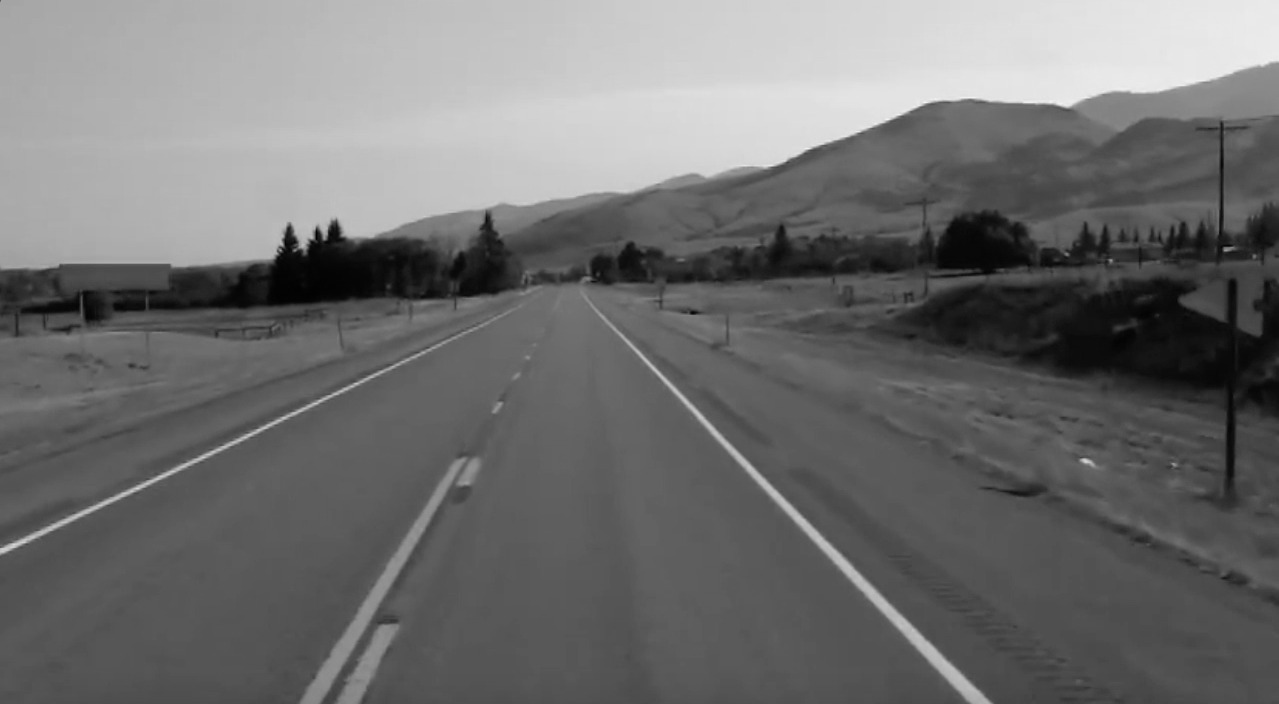

In [ ]:
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
cv2_imshow(gray_image)

# Applying Filters

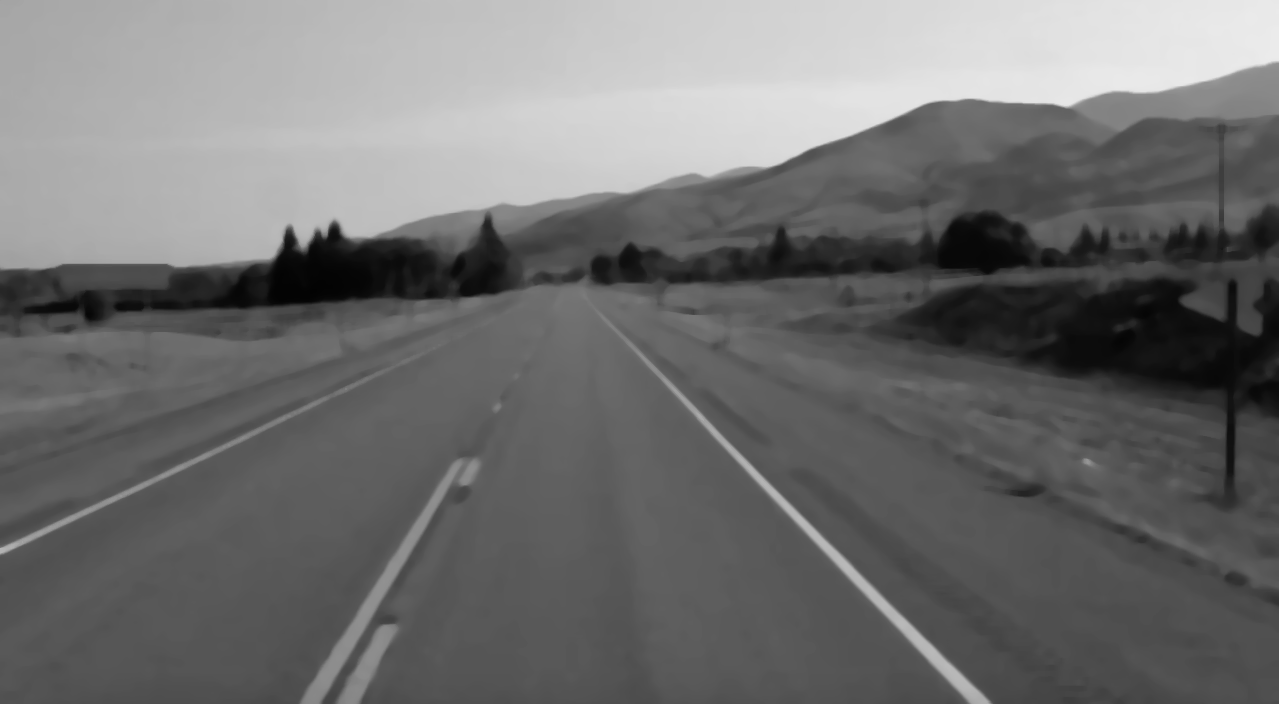

In [ ]:
# Smoothing the Image
kernel_size = 9
smoothed_image = cv2.medianBlur(gray_image, kernel_size)
cv2_imshow(smoothed_image)

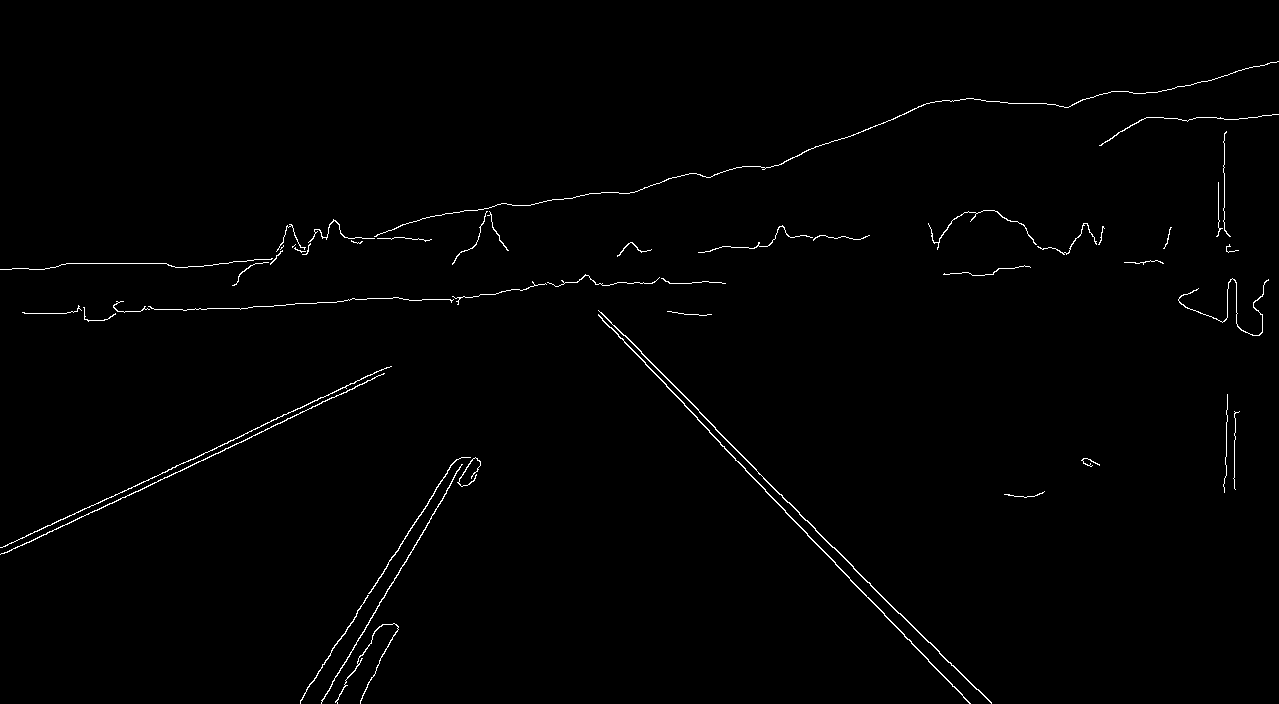

In [ ]:
# Applying Edge Detection
lower_threshold = 50
upper_threshold = 150
edges = cv2.Canny(smoothed_image, lower_threshold, upper_threshold)
cv2_imshow(edges)

# Extract The Region Of Interest

In [ ]:
def region_of_interest(smoothed_image, canned_image):
  h, w = smoothed_image.shape
  mask = np.zeros_like(smoothed_image)
  cv2.rectangle(mask, (0, int(0.5*h)), (w, h), 255, -1)
  mask_img = cv2.bitwise_and(canned_image, canned_image , mask = mask)
  cv2_imshow(mask_img)
  return mask_img

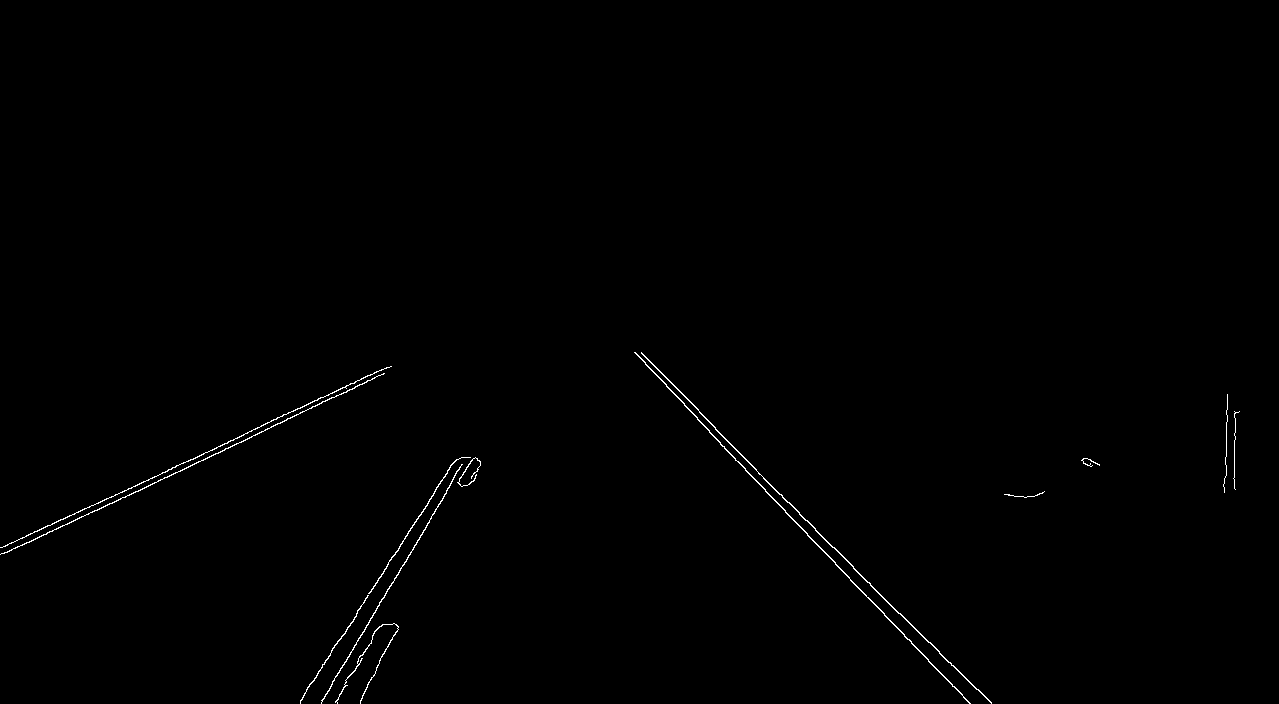

In [ ]:
mask_img = region_of_interest(smoothed_image, edges)

# Applying Hough Transform

In [ ]:
def hough_transform_line(mask_image, num_rhos=180, theta_resolution=1):
    edge_height, edge_width = mask_image.shape[:2]

    diagonal = np.sqrt(np.square(edge_height) + np.square(edge_width))
    drho = (2 * diagonal) / num_rhos

    theta_values = np.arange(0, 180, step=theta_resolution)
    rho_values = np.arange(-diagonal, diagonal, step=drho)

    cos_thetas = np.cos(np.deg2rad(theta_values))
    sin_thetas = np.sin(np.deg2rad(theta_values))

    accumulator = np.zeros((len(rho_values), len(theta_values)))

    for y in range(edge_height):
        for x in range(edge_width):
            if mask_image[y][x] != 0:
                for theta_idx in range(len(theta_values)):
                    rho = ((x - (edge_width / 2)) * cos_thetas[theta_idx]) + ((y - (edge_height / 2)) * sin_thetas[theta_idx])
                    rho_idx = np.argmin(np.abs(rho_values - rho))
                    accumulator[rho_idx][theta_idx] += 1

    return accumulator,  rho_values, theta_values

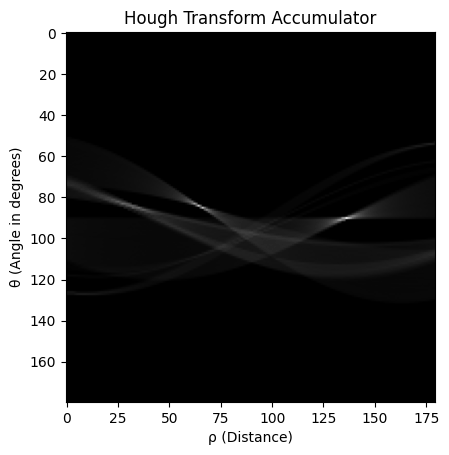

In [ ]:
accumulator,  rho_values, theta_values = hough_transform_line(mask_img)
# Plot the accumulator array as an image
plt.imshow(accumulator, cmap='gray')
plt.title("Hough Transform Accumulator")
plt.xlabel("ρ (Distance)")
plt.ylabel("θ (Angle in degrees)")
plt.show()

In [ ]:
def non_maximum_suppression(sorted_indices, accumulator, distance_threshold):

    for index in sorted_indices:
        if accumulator[index[0], index[1]] > 0:
            for i in range(-distance_threshold, distance_threshold + 1):
                for j in range(-distance_threshold, distance_threshold + 1):
                    if i != 0 or j != 0:
                        neighbor_index = (index[0] + i, index[1] + j)
                        if 0 <= neighbor_index[0] < accumulator.shape[0] and 0 <= neighbor_index[1] < accumulator.shape[1]:
                            accumulator[neighbor_index[0], neighbor_index[1]] = 0

    return accumulator

In [ ]:
peak_indices = np.argwhere(accumulator > 50)
sorted_peak_indices = peak_indices[np.argsort(accumulator[peak_indices[:, 0], peak_indices[:, 1]])[::-1]]
acc_after_suppression = non_maximum_suppression(sorted_peak_indices, accumulator, distance_threshold = 20)

In [ ]:
def draw_lines(img, accumulator, rho_values, theta_values, t_count = 500):
  mask_height, mask_width = mask_img.shape[:2]
  lines_img = img.copy()

  for x in range(accumulator.shape[0]):
      for y in range(accumulator.shape[1]):
          if accumulator[x][y] > t_count:
              rho = rho_values[x]
              theta = theta_values[y]
              a = np.cos(np.deg2rad(theta))
              b = np.sin(np.deg2rad(theta))
              x0 = (a * rho) + (mask_width / 2)
              y0 = (b * rho) + (mask_height / 2)
              x1 = int(x0 + 1000 * (-b))
              y1 = int(y0 + 1000 * (a))
              x2 = int(x0 - 1000 * (-b))
              y2 = int(y0 - 1000 * (a))

              lines_img = cv2.line(lines_img, (x1,y1), (x2,y2), (0,255,0), 2)
              lines_img[0:360,:] = img[0:360,:]

  return lines_img

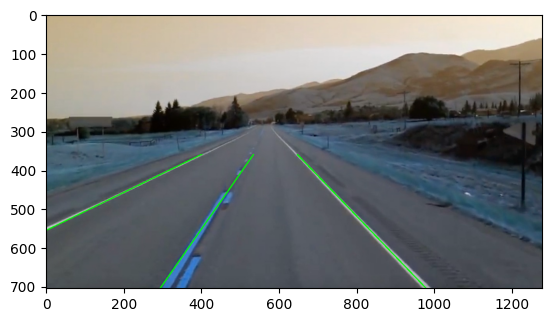

In [ ]:
line_img = draw_lines(image, acc_after_suppression, rho_values, theta_values)
plt.imshow(line_img)